# Filtering and Trimming Messages

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Messages as state

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly interactive and can often be seen riding the waves near boats.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with a different snout shape. They are often found in coastal waters.\n\n3. **Sea Lions**: These pinnipeds are known for their loud barking and playful nature. They can often be seen lounging on rocks or beaches.\n\n4. **Seals**: Another group of pinnipeds, seals are typically more streamlined and less social than sea lions. They can be found in various habitats, including icy waters.\n\n5. **Manatees**: Also known as sea cows, these gentle giants are herbivorous and inhabit warm, shallow waters. They are known for their slow-moving nature.\n\n6. **Dugongs**: Similar to manatees, dugongs are also herbivorous and primarily feed on seagrass. They are found 

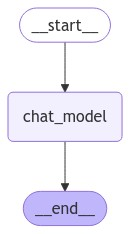

In [4]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph, START, END

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, here are some other fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are part of the cetacean family, which includes whales and porpoises.

2. **Porpoises**: Similar to dolphins but generally smaller and with different physical characteristics, porpoises are also part of the cetacean family and are known for their shy nature.

3. **Sea Lions**: These pinnipeds are known for their external ear flaps and social behavior. They can often be seen lounging on rocks or beaches.

4. **Seals**: Another group of pin

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

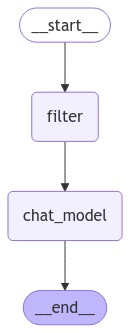

In [6]:
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

/var/folders/3d/p7qkh78d27d28q35f5nt84y40000gp/T/ipykernel_90539/820294666.py:4: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins** - Highly intelligent and social, dolphins are known for their playful behavior and complex communication skills. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises** - Similar to dolphins but generally smaller and with different teeth and snouts, porpoises are also social creatures that inhabit coastal waters.

3. **Seals** - There are several types of seals, including harbor seals and elephant seals. They are known for their playful nature and can be found on various coast

## Filtering Messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

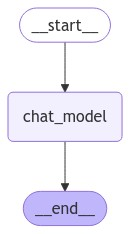

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins** - Highly intelligent and social, dolphins are known for their playful behavior and complex communication skills. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises** - Similar to dolphins but generally smaller and with different teeth and snouts, porpoises are also social creatures t

In [10]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins** - Highly intelligent and social, dolphins are known for their playful behavior and complex communication skills. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises** - Similar to dolphins but generally smaller and with different teeth and snouts, porpoises are also social creatures t

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/o/7733aa42-7fa1-584c-b6b6-3775fbe407d6/projects/p/7f9c2534-1e75-4018-ba6e-915f36895c94?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=bc6de717-20dc-4c81-89f6-c32f2d5beda8

## Trim Messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

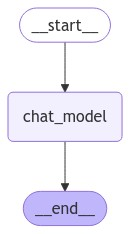

In [11]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [13]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [14]:
# Invoke, using message trimming
messages_out_trim = graph.invoke({'messages': messages})

In [15]:
for m in messages_out_trim['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to learn about:

1. **Dolphins** - Highly intelligent and social, dolphins are known for their playful behavior and complex communication skills. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises** - Similar to dolphins but generally smaller and with different teeth and snouts, porpoises are also social creatures t